# ViT & CNN

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.transforms import v2
import timm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import os
from tqdm.notebook import tqdm

In [3]:
class FlowerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
class ViTFlowerClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)

        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

In [5]:
class CNNFlowerClassifier(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.resnet = models.resnet50(pretrained=True)

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

In [6]:
def create_data_splits(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-5, "Ratios must sum to 1"

    total_size = len(dataset)
    train_size = int(train_ratio * total_size)
    val_size = int(val_ratio * total_size)
    test_size = total_size - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(seed)
    )

    return train_dataset, val_dataset, test_dataset

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_acc = 0.0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_{model.__class__.__name__}.pth')

    return train_losses, train_accs, val_losses, val_accs

In [9]:
def plot_metrics(train_losses, train_accs, val_losses, val_accs, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [13]:
def main():
    # Random seed for reproducibility
    torch.manual_seed(42)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Data augmentation and normalization
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Full dataset
    dataset_path = '/kaggle/input/flowers-dataset/train'
    full_dataset = FlowerDataset(dataset_path, transform=None)

    # Splitting dataset
    train_dataset, val_dataset, test_dataset = create_data_splits(full_dataset)

    # Applying transforms
    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform
    test_dataset.dataset.transform = val_transform

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Training parameters
    num_epochs = 20
    criterion = nn.CrossEntropyLoss()

    # ViT
    print("\nTraining Vision Transformer...")
    vit_model = ViTFlowerClassifier().to(device)
    vit_optimizer = optim.AdamW(vit_model.parameters(), lr=2e-4, weight_decay=0.01)
    vit_metrics = train_model(vit_model, train_loader, val_loader, criterion,
                             vit_optimizer, num_epochs, device)
    plot_metrics(*vit_metrics, "Vision Transformer")

    # CNN
    print("\nTraining CNN (ResNet50)...")
    cnn_model = CNNFlowerClassifier().to(device)
    cnn_optimizer = optim.AdamW(cnn_model.parameters(), lr=2e-4, weight_decay=0.01)
    cnn_metrics = train_model(cnn_model, train_loader, val_loader, criterion,
                             cnn_optimizer, num_epochs, device)
    plot_metrics(*cnn_metrics, "CNN (ResNet50)")

    # Evaluation of both models
    print("\nEvaluating Vision Transformer...")
    evaluate_model(vit_model, test_loader, device, full_dataset.classes)

    print("\nEvaluating CNN...")
    evaluate_model(cnn_model, test_loader, device, full_dataset.classes)


Training Vision Transformer...


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 1.3723, Train Acc: 44.28%
Val Loss: 1.0379, Val Acc: 61.07%


Epoch 2/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.7071, Train Acc: 73.62%
Val Loss: 0.6853, Val Acc: 74.94%


Epoch 3/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.3867, Train Acc: 84.60%
Val Loss: 0.5079, Val Acc: 82.48%


Epoch 4/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.2919, Train Acc: 89.02%
Val Loss: 0.4889, Val Acc: 82.48%


Epoch 5/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 0.1681, Train Acc: 93.96%
Val Loss: 1.0655, Val Acc: 74.45%


Epoch 6/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: 0.1759, Train Acc: 93.76%
Val Loss: 0.6978, Val Acc: 82.73%


Epoch 7/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: 0.0883, Train Acc: 96.51%
Val Loss: 0.6526, Val Acc: 82.97%


Epoch 8/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: 0.0493, Train Acc: 98.28%
Val Loss: 0.7317, Val Acc: 83.94%


Epoch 9/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9/20:
Train Loss: 0.0895, Train Acc: 96.88%
Val Loss: 0.7739, Val Acc: 79.81%


Epoch 10/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10/20:
Train Loss: 0.0886, Train Acc: 97.40%
Val Loss: 0.9023, Val Acc: 81.75%


Epoch 11/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 11/20:
Train Loss: 0.0971, Train Acc: 96.98%
Val Loss: 0.6524, Val Acc: 83.94%


Epoch 12/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 12/20:
Train Loss: 0.0620, Train Acc: 97.61%
Val Loss: 0.6881, Val Acc: 79.81%


Epoch 13/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 13/20:
Train Loss: 0.0425, Train Acc: 98.86%
Val Loss: 0.5868, Val Acc: 82.24%


Epoch 14/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 14/20:
Train Loss: 0.0088, Train Acc: 99.64%
Val Loss: 0.7163, Val Acc: 84.43%


Epoch 15/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 15/20:
Train Loss: 0.0015, Train Acc: 99.95%
Val Loss: 0.8133, Val Acc: 82.00%


Epoch 16/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 16/20:
Train Loss: 0.0004, Train Acc: 100.00%
Val Loss: 0.8301, Val Acc: 81.75%


Epoch 17/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 17/20:
Train Loss: 0.0001, Train Acc: 100.00%
Val Loss: 0.8091, Val Acc: 83.45%


Epoch 18/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 18/20:
Train Loss: 0.0000, Train Acc: 100.00%
Val Loss: 0.8188, Val Acc: 83.45%


Epoch 19/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 19/20:
Train Loss: 0.0000, Train Acc: 100.00%
Val Loss: 0.8290, Val Acc: 83.21%


Epoch 20/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 20/20:
Train Loss: 0.0000, Train Acc: 100.00%
Val Loss: 0.8389, Val Acc: 83.21%


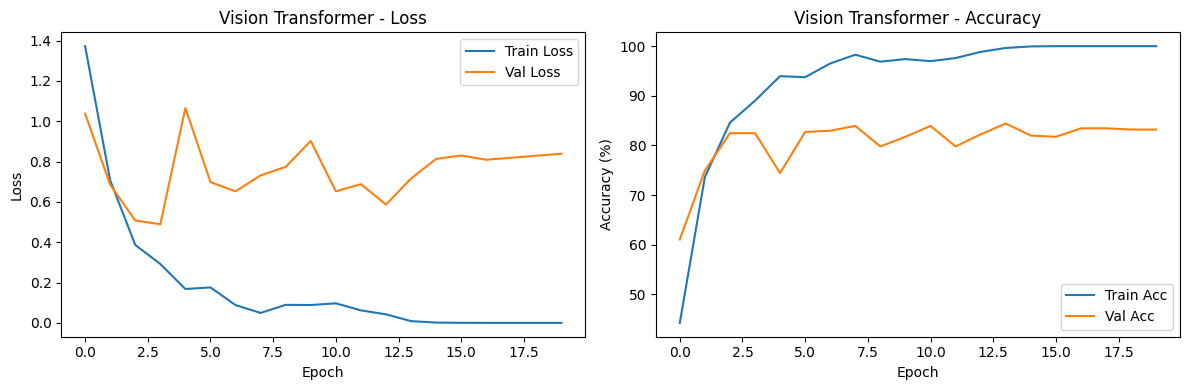


Training CNN (ResNet50)...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 218MB/s]


Epoch 1/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 0.4561, Train Acc: 84.70%
Val Loss: 0.2934, Val Acc: 89.05%


Epoch 2/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.1725, Train Acc: 94.54%
Val Loss: 0.2863, Val Acc: 90.27%


Epoch 3/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.1386, Train Acc: 95.79%
Val Loss: 0.2496, Val Acc: 92.70%


Epoch 4/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.1381, Train Acc: 96.51%
Val Loss: 0.2844, Val Acc: 89.29%


Epoch 5/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 0.1268, Train Acc: 95.99%
Val Loss: 0.2987, Val Acc: 91.24%


Epoch 6/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: 0.0519, Train Acc: 98.65%
Val Loss: 0.2299, Val Acc: 92.94%


Epoch 7/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: 0.1080, Train Acc: 96.25%
Val Loss: 0.3565, Val Acc: 87.83%


Epoch 8/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: 0.1135, Train Acc: 96.25%
Val Loss: 0.6239, Val Acc: 83.21%


Epoch 9/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9/20:
Train Loss: 0.1460, Train Acc: 97.24%
Val Loss: 0.2613, Val Acc: 91.48%


Epoch 10/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10/20:
Train Loss: 0.1254, Train Acc: 96.62%
Val Loss: 0.3893, Val Acc: 89.05%


Epoch 11/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 11/20:
Train Loss: 0.0502, Train Acc: 98.60%
Val Loss: 0.3015, Val Acc: 90.75%


Epoch 12/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 12/20:
Train Loss: 0.0719, Train Acc: 98.65%
Val Loss: 0.3388, Val Acc: 91.97%


Epoch 13/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 13/20:
Train Loss: 0.1165, Train Acc: 96.83%
Val Loss: 0.3279, Val Acc: 89.05%


Epoch 14/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 14/20:
Train Loss: 0.0669, Train Acc: 99.12%
Val Loss: 0.3874, Val Acc: 89.05%


Epoch 15/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 15/20:
Train Loss: 0.1064, Train Acc: 97.24%
Val Loss: 0.3838, Val Acc: 89.05%


Epoch 16/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 16/20:
Train Loss: 0.1402, Train Acc: 97.81%
Val Loss: 0.2668, Val Acc: 91.48%


Epoch 17/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 17/20:
Train Loss: 0.1121, Train Acc: 96.46%
Val Loss: 0.2544, Val Acc: 90.75%


Epoch 18/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 18/20:
Train Loss: 0.1114, Train Acc: 99.01%
Val Loss: 0.2996, Val Acc: 91.48%


Epoch 19/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 19/20:
Train Loss: 0.1059, Train Acc: 97.87%
Val Loss: 0.2828, Val Acc: 90.51%


Epoch 20/20:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 20/20:
Train Loss: 0.0982, Train Acc: 97.19%
Val Loss: 0.4069, Val Acc: 87.83%


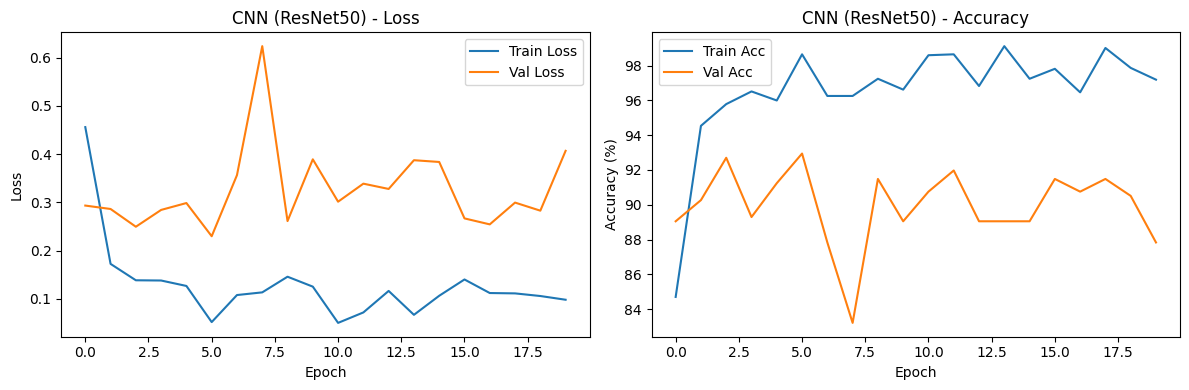


Evaluating Vision Transformer...

Classification Report:
              precision    recall  f1-score   support

       daisy       0.93      0.91      0.92        85
   dandelion       0.88      0.91      0.89        85
        rose       0.80      0.69      0.74        64
   sunflower       0.92      0.93      0.93        73
       tulip       0.78      0.83      0.80       106

    accuracy                           0.86       413
   macro avg       0.86      0.85      0.86       413
weighted avg       0.86      0.86      0.86       413



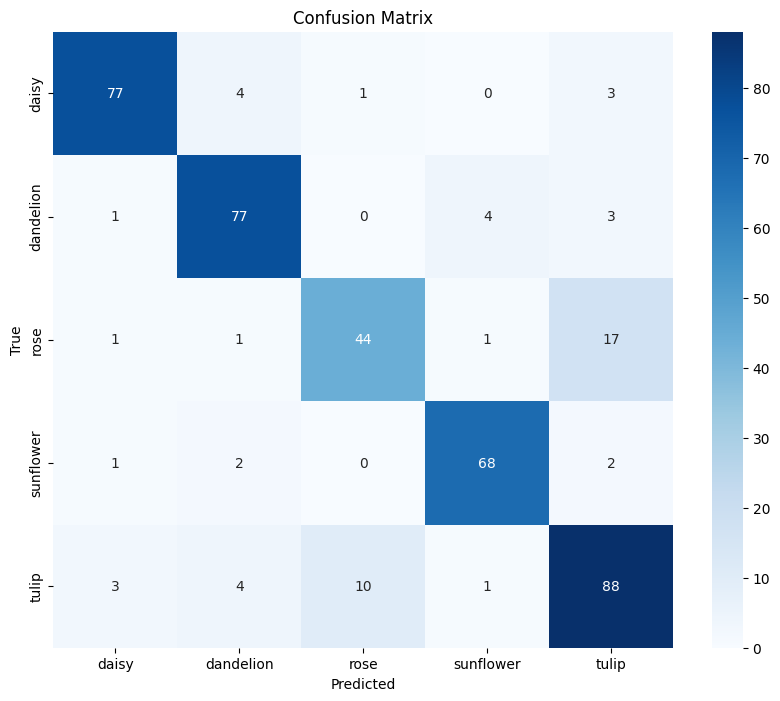


Evaluating CNN...

Classification Report:
              precision    recall  f1-score   support

       daisy       0.94      0.86      0.90        85
   dandelion       0.85      0.96      0.90        85
        rose       0.72      0.92      0.81        64
   sunflower       0.99      0.92      0.95        73
       tulip       0.93      0.77      0.85       106

    accuracy                           0.88       413
   macro avg       0.88      0.89      0.88       413
weighted avg       0.89      0.88      0.88       413



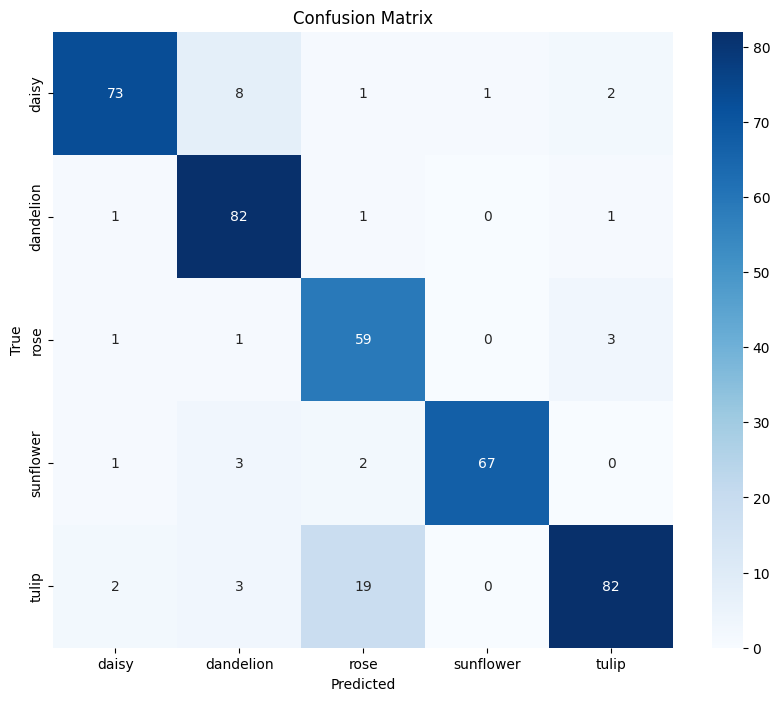

In [14]:
if __name__ == '__main__':
    main()

# Benefits and Limitations of ViT

## Benefits:


*   Better at capturing global dependencies in images
*   Can handle varying flower orientations and scales well
*   Generally requires less manual feature engineering
*   Often performs better with limited data due to self-attention mechanism


## Limitations:

*   Computationally more expensive than CNNs
*   May be overkill for this relatively simple classification task
*   Requires more memory during training
*   Can be slower to train than CNNs